In [157]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import loadtxt
import os, glob
import geopandas as gpd
import geojsonio
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import math
from IPython.display import Image

import plotly
import plotly.express as px
import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)
cf.go_offline()
%matplotlib inline
#pd.options.plotting.backend = "plotly"

In [158]:
# Dashboard
target="price"
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 100)
pd.options.display.max_seq_items = 300
pd.set_option('display.max_colwidth', 150)
sns.set(style="white")

In [159]:
# Import data_clean
data = pd.read_pickle("saves/data_clean.pkl")

In [160]:
# Alternative: Import from csv
#data_types_clean = pd.read_csv('saves/types_clean.csv')['types']
#data = pd.read_csv("saves/data_clean.csv", dtype=data_types_clean.to_dict())
#data.set_index('id', inplace=True)

# Data Exploration

In [161]:
# Separate/create variables for numerical and categorical features
num_features = list(data.columns[data.dtypes!=object])
cat_features = list(data.columns[data.dtypes==object])
#data_cont = data[num_features]

## Interactive Dashboards

In [162]:
# Display figures from graphical exploration below direcly here in the dashboard
@interact_manual
def show_images(file=os.listdir('data/figures/')):
    display(Image("data/figures/"+file))

interactive(children=(Dropdown(description='file', options=('3_fig1_heatmap.png', 'fig1_heatmap.png', 'fig3_ma…

In [163]:
# Display table with all rows where feature value is > x (where x is the selected threshold)
@interact(x=widgets.IntSlider(1,0,100,1,continuous_update=False))
def filter_data(column=num_features, x=10):
    return data.loc[data[column]>x]

interactive(children=(Dropdown(description='column', options=('accommodates', 'am_balcony', 'am_breakfast', 'a…

In [164]:
# Display interactive plot for comparing two features
@interact_manual(x=widgets.Dropdown(options=list(data.select_dtypes('number').columns),index=0,description="Feature"),
                 y=widgets.Dropdown(options=list(data.select_dtypes('number').columns),value=target,description="Target"),
                 kind=widgets.Dropdown(options=["bar", "box", "bubble", "heatmap", "histogram", "scatter"],value="bar",description="Plot Type"))
#                 text='title',
#                 theme=widgets.Dropdown(options=list(cf.themes.THEMES.keys()),description="Theme"),
#                 colorscale=widgets.Dropdown(options=list(cf.colors._scales_names.keys()),description="Colorscale"))


def scatter_plot(x,y, kind):#,theme,colorscale):

    data.iplot(
        kind=kind,
        x=x,
        y=y,
        mode='markers',
        xTitle=str(x),
        yTitle=str(y),
        title=f'{str(y)} vs {str(x)}')
#        text=title,
#        theme=theme,
#        colorscale=colorscale)

interactive(children=(Dropdown(description='Feature', options=('accommodates', 'am_balcony', 'am_breakfast', '…

## Tables (non-graphical exploration)

In [165]:
# Examine shape and head/columns of data
print(data.shape)
data.head(1)

(23854, 51)


,accommodates,am_balcony,am_breakfast,am_child_friendly,am_coffee_machine,am_cooking_basics,am_elevator,am_essentials,am_nature_and_views,am_parking,am_pets_allowed,am_private_entrance,am_smoking_allowed,am_tv,am_white_goods,amenities,availability_365,bathrooms,bedrooms,beds,calculated_host_listings_count,cancellation_policy,cleaning_fee,description,extra_people,guests_included,host_identity_verified,host_is_superhost,house_rules,instant_bookable,interaction,is_location_exact,latitude,longitude,maximum_nights,minimum_nights,monthly_price,name,neighborhood_overview,neighbourhood,notes,price,property_type,review_scores_rating,room_type,security_deposit,space,summary,transit,weekly_price,zipcode
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015,3,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,"{TV,""Cable TV"",Wifi,Kitchen,Gym,""Free street parking"",Heating,""Family/kid friendly"",""Smoke detector"",Essentials,Shampoo,""Lock on bedroom door"",Han...",194,1.0,1.0,1.0,6,strict_14_with_grace_period,30.0,"Great location! 30 of 75 sq meters. This wood floored/high ceiling typical Berlin ""Altbau"" section of an apartment consists of 1 simple large roo...",28.0,1,t,f,"No parties No events No pets No smoking, not even in the courtyard/garden Do not pull the door shut with the keys in the lock from the inside; sho...",f,Always available,f,52.53454,13.40256,1125,4,0.0,Berlin-Mitte Value! Quiet courtyard/very central,"It is located in the former East Berlin area of Kastanienallee and Zionskirchplatz (Berlins only natural elevation), very charming and original tu...",Mitte,"This is my home, not a hotel. I rent out occasionally when I stay with my friend.",60.0,Guesthouse,93.0,Entire home/apt,250.0,"A+++ location! This „Einliegerwohnung“ is an extention of a larger apartment with a separate entrance, bathroom and kitchen. The door to the rest ...","Great location! 30 of 75 sq meters. This wood floored/high ceiling typical Berlin ""Altbau"" section of an apartment consists of 1 simple large roo...","Close to U-Bahn U8 and U2 (metro), Trams M12, M10 and M8, Busses. Rosenthaler Platz and Hackescher Markt are close by. S-Bahn. Alexander Platz is ...",0.0,zip_10119


**Outliers**

In [166]:
# Examine illogical column values (e.g. "accommodates" < "guests_included", "bedrooms" > "beds", ...)
data[data.accommodates-data.beds < 0]

,accommodates,am_balcony,am_breakfast,am_child_friendly,am_coffee_machine,am_cooking_basics,am_elevator,am_essentials,am_nature_and_views,am_parking,am_pets_allowed,am_private_entrance,am_smoking_allowed,am_tv,am_white_goods,amenities,availability_365,bathrooms,bedrooms,beds,calculated_host_listings_count,cancellation_policy,cleaning_fee,description,extra_people,guests_included,host_identity_verified,host_is_superhost,house_rules,instant_bookable,interaction,is_location_exact,latitude,longitude,maximum_nights,minimum_nights,monthly_price,name,neighborhood_overview,neighbourhood,notes,price,property_type,review_scores_rating,room_type,security_deposit,space,summary,transit,weekly_price,zipcode
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


**Skew**

In [167]:
# Look at data skew (to check whether scaling with e.g. log makes sense for highly skewed features)
data.skew()

accommodates                      2.432717
am_balcony                        1.815828
am_breakfast                      3.888195
am_child_friendly                 0.931645
am_coffee_machine                 1.023686
am_cooking_basics                 0.672284
am_elevator                       1.342204
am_essentials                    -3.086349
am_nature_and_views               6.081675
am_parking                        0.364968
am_pets_allowed                   1.840009
am_private_entrance               1.850568
am_smoking_allowed                1.615067
am_tv                             0.187635
am_white_goods                   -1.853965
availability_365                  1.556243
bathrooms                         6.672137
bedrooms                          2.695761
beds                              3.297961
calculated_host_listings_count    7.032084
cleaning_fee                      2.961873
extra_people                      3.804400
guests_included                   4.169413
latitude   

Based on skew, log/sqrt shall replace the original feature for:

| **FEATURE** | **METHOD** |
| :----- | :----- |
| **accommodates** | log |
| **bathrooms** | log |
| **minimum_nights** | log |
| **price** | log |
| **review_scores_rating** | sqrt |


**Correlation**

In [168]:
# Interactive feature vs. feature correlation check
@interact
def correlations(column1=list(data.select_dtypes('number').columns),
                 column2=list(data.select_dtypes('number').columns)):
    print(f"Correlation: {data[column1].corr(data[column2])}")

interactive(children=(Dropdown(description='column1', options=('accommodates', 'am_balcony', 'am_breakfast', '…

In [169]:
# Full list of correlation values
data.corr()

,accommodates,am_balcony,am_breakfast,am_child_friendly,am_coffee_machine,am_cooking_basics,am_elevator,am_essentials,am_nature_and_views,am_parking,am_pets_allowed,am_private_entrance,am_smoking_allowed,am_tv,am_white_goods,availability_365,bathrooms,bedrooms,beds,calculated_host_listings_count,cleaning_fee,extra_people,guests_included,latitude,longitude,maximum_nights,minimum_nights,monthly_price,price,review_scores_rating,security_deposit,weekly_price
accommodates,1.000000,0.111376,-0.014540,0.301535,0.183243,0.155283,0.063103,0.028590,0.022235,0.153050,0.078063,0.176822,-0.104942,0.244103,0.028512,0.186755,0.243743,0.688733,0.808884,0.211663,0.387396,0.238849,0.578432,0.019820,-0.001452,0.069992,-0.020130,0.092758,0.570845,-0.054228,0.103666,0.091996
am_balcony,0.111376,1.000000,-0.025513,0.080818,0.425067,0.528970,0.123931,0.096361,0.136393,0.299045,0.022343,0.076429,-0.034581,0.122519,0.099125,0.070881,0.069157,0.100278,0.079248,-0.028252,0.161041,0.106351,0.115826,0.015690,-0.004124,-0.031397,-0.000250,0.026512,0.155238,0.090798,0.084872,0.017234
am_breakfast,-0.014540,-0.025513,1.000000,-0.015211,-0.028239,-0.050299,0.017017,0.041937,-0.003592,-0.010037,0.026739,0.017513,0.027541,0.000439,-0.002254,0.003689,-0.020574,-0.020475,-0.025311,-0.025078,-0.040484,0.001607,-0.027390,0.006802,-0.015666,-0.028889,-0.039542,-0.041384,0.024079,0.015644,-0.015691,-0.051728
am_child_friendly,0.301535,0.080818,-0.015211,1.000000,0.101261,0.086894,0.028162,-0.005416,0.011568,0.131063,0.074207,0.009185,-0.077251,0.140522,0.044958,0.090663,0.063574,0.260431,0.272164,0.044754,0.191656,0.128808,0.225877,0.021535,0.006299,0.002769,0.031273,0.157997,0.196682,-0.019131,0.083695,0.179703
am_coffee_machine,0.183243,0.425067,-0.028239,0.101261,1.000000,0.670684,0.049347,0.127839,0.123907,0.397765,0.019580,0.138146,-0.078186,0.176662,0.074621,0.210815,0.054627,0.118334,0.148005,0.108612,0.221538,0.167220,0.187435,0.036014,-0.033512,-0.034375,-0.006626,0.048577,0.185453,0.066046,0.089918,0.020659
am_cooking_basics,0.155283,0.528970,-0.050299,0.086894,0.670684,1.000000,0.037661,0.157264,0.135676,0.439305,0.027555,0.123193,-0.066998,0.119054,0.124255,0.150168,0.032549,0.086563,0.115475,-0.002048,0.206626,0.179023,0.162650,0.029944,-0.014540,-0.040299,-0.010290,0.040183,0.156716,0.076752,0.082356,0.014689
am_elevator,0.063103,0.123931,0.017017,0.028162,0.049347,0.037661,1.000000,0.021397,0.026393,0.050805,-0.012839,0.026067,-0.035725,0.155800,0.040335,0.075346,0.098850,0.036779,0.035745,0.099401,0.107740,0.032401,0.036192,0.044211,-0.045388,0.012027,0.062490,0.036413,0.180812,-0.004384,0.085243,0.024223
am_essentials,0.028590,0.096361,0.041937,-0.005416,0.127839,0.157264,0.021397,1.000000,0.031585,0.154161,0.023346,0.087674,-0.000983,0.020882,0.053365,0.039978,0.012531,0.007496,0.013390,-0.070685,0.061501,0.045651,0.028580,0.015161,-0.007249,-0.031739,-0.009681,-0.053701,0.046148,0.061968,0.026591,-0.082727
am_nature_and_views,0.022235,0.136393,-0.003592,0.011568,0.123907,0.135676,0.026393,0.031585,1.000000,0.123898,0.028877,0.050617,-0.010328,0.051419,0.009206,0.052966,0.015804,0.011204,0.014954,-0.006213,0.039764,0.039447,0.031796,-0.030268,0.008382,-0.003478,-0.014027,-0.009102,0.025741,0.010572,0.025311,-0.011691
am_parking,0.153050,0.299045,-0.010037,0.131063,0.397765,0.439305,0.050805,0.154161,0.123898,1.000000,0.053672,0.132365,-0.064418,0.152203,0.042702,0.206018,0.054626,0.095577,0.132217,0.050211,0.173628,0.149515,0.139577,-0.013650,-0.021341,-0.048016,0.001965,0.045132,0.130963,0.048727,0.077021,0.018807


## Plot visualizations (graphical exploration)

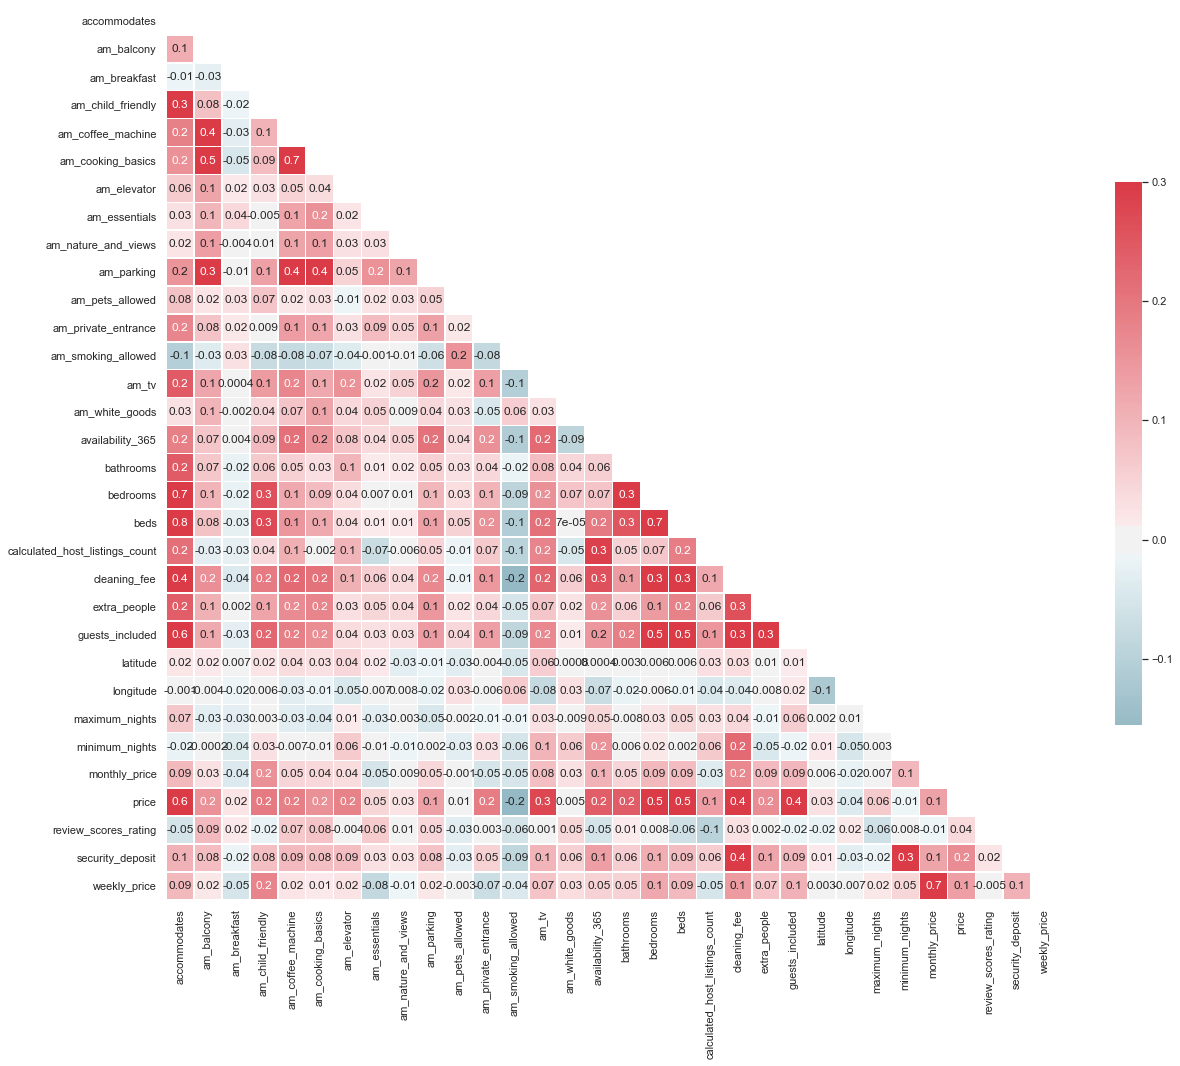

In [170]:
# Plot correlation heatmap for numerical features
#Generate a mask for the upper triangle
mask = np.triu(np.ones_like(data[num_features].corr(), dtype=np.bool))

#Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

#Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data[num_features].corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".1g");

plt.savefig("data/figures/fig1_heatmap.png")

Highly correlated features will be removed from the analysis. For this purpose, the threshold is set at two correlations of 0.4 or above. Hence, the following features are removed:

| **FEATURE** | **REASONING** |
| :----- | :----- |
| **am_cooking_basics** | Particularly high correlation with **am_coffee_machine** and **am_balcony** |
| **bedroom** and **beds** | High correlation with each other, with **accommodates** and similar correlation with other features: Combine the two features to one (bed_proxy) |
| **guests_included** | High correlation with many features |
| **security_deposit** and **space** | Similar correlation to **cleaning_fee** or **extra_people**: Potentially make a numerical feature counting amount of "special" features instead (0-4) |
| **** |  |



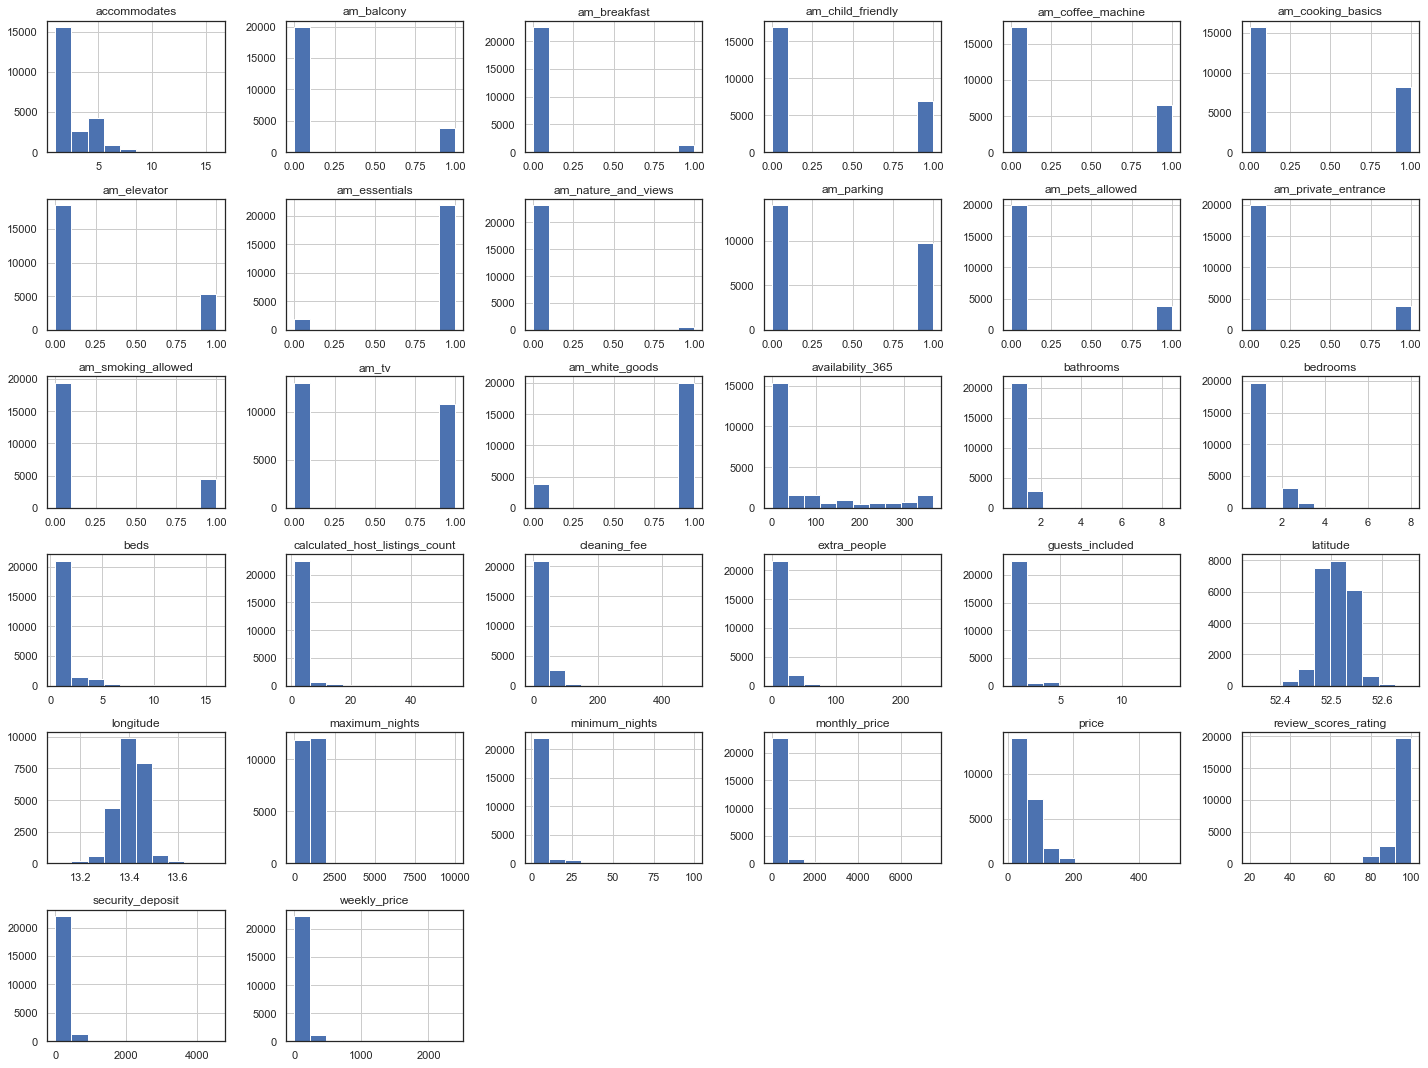

In [171]:
# Plot histogram of numerical features
data[num_features].hist(figsize=(20,15));
plt.tight_layout()

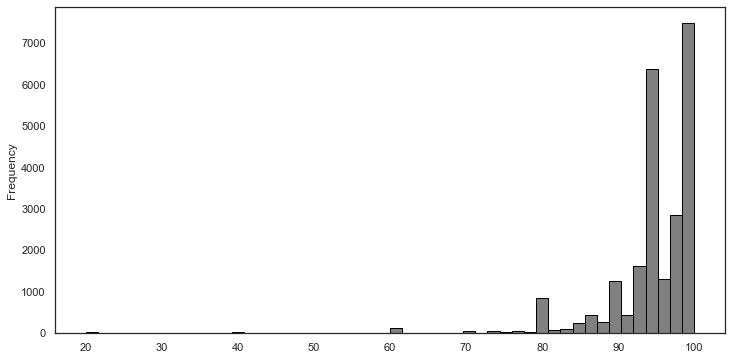

In [172]:
# Plot histogram of skewed feature
data.review_scores_rating.plot(kind='hist', bins=50, figsize=(12,6), facecolor='grey',edgecolor='black');
plt.savefig("data/figures/fig2_histogram_review_scores.png")

In [173]:
fig = go.Figure(data=go.Bar(y=[2, 3, 1]))
fig.show()

## Map visualizations (graphical exploration)

In [174]:
# Display contents of neighbourhoods.geojson visually

# Load up the file
data_2019_12_11_neighb_geojson = gpd.read_file('data/2019-12-11/neighbourhoods.geojson')

# Dropping the redundant column
data_2019_12_11_neighb_geojson.drop('neighbourhood_group', axis=1, inplace=True)

# Creating a dataframe of listing counts and median price by borough
neighbourhood_df = pd.DataFrame(data.groupby('neighbourhood').size())
neighbourhood_df.rename(columns={0: 'number_of_listings'}, inplace=True)
neighbourhood_df['median_price'] = data.groupby('neighbourhood').price.median().values

# Joining the dataframes
neighbourhood_map_df = data_2019_12_11_neighb_geojson.set_index('neighbourhood').join(neighbourhood_df)

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning:

invalid value encountered in less



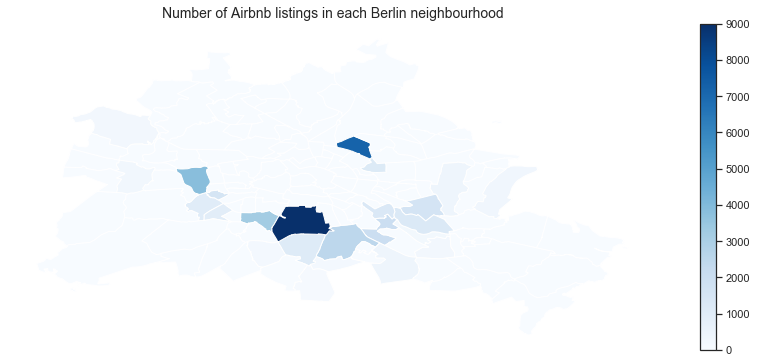

In [175]:
# Plotting the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
neighbourhood_map_df.plot(column='number_of_listings', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each Berlin neighbourhood', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.savefig("data/figures/fig3_map_listings_neighbourhood.png")

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning:

invalid value encountered in less



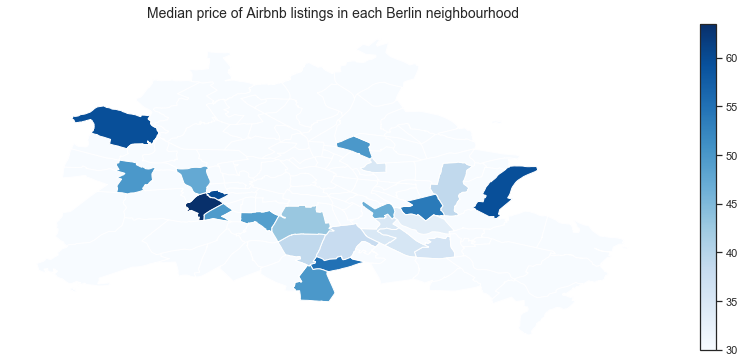

In [176]:
# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
neighbourhood_map_df.plot(column='median_price', cmap='Blues', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each Berlin neighbourhood', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(neighbourhood_map_df.median_price), vmax=max(neighbourhood_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.savefig("data/figures/fig4_map_median_price_neighbourhood.png")